Small Message Latency Loopback vs X-socket vs X-node (TODO add a 2 hop latency)

In [2]:
import matplotlib
import numpy as np
from os import listdir
from os.path import isfile, join
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
nvhostpath = "../results/summit/host/standard/nvshmem/02-20-20.14.04.48/nvtests/host"
nvhostpath2 = "../results/summit/host/standard/nvshmem/push_and_pull_nv_hostinit/nvtests/host"
nvdevpath = "../results/summit/device/standard/nvshmem/02-20-20.14.04.48/nvtests/device"
# write to GPU doesn't work in IB perftest since the test relies on direct memory polling from the CPU
# https://github.com/linux-rdma/perftest/issue
#ibpath = "../results/summit/device/standard/ib/02-03-20.12.58.07/device"


f_ib_xnode = "ib_read_lat.xnode"
#original run with default
f_nv = "latency.out"
#added option to get both put and get
f_nv_host_get = "latency_get.out"
f_nv_host_put = "latency_put.out"
f_nv_dev_put = "shmem_put_latency.out"
f_nv_dev_get = "shmem_get_latency.out"

In [4]:
#output format is min, max, typical, avg, stddev, 99th, 99.9 
#unit is usec
def read_ib_lat(msg_size, file):
    data = {}
    with open(file, 'r') as f:
        for line in f.readlines():
            #print(line)
            tmp = line.lstrip().split()
            if tmp == []:
                continue
            elif tmp[0] == str(msg_size):
                data["tmin"] = tmp[2]
                data["tmax"] = tmp[3]
                data["tmed"] = tmp[4]
                data["tavg"] = tmp[5]
                data["tstd"] = tmp[6]
                return data
        return None
    
def read_nvshmem_lat(msg_size, file):
    data = {}
    with open(file, 'r') as f:
        for line in f.readlines():
            #print(line)
            tmp = line.lstrip().split()
            if tmp == []:
                continue
            elif tmp[0] == str(msg_size):
                data["tavg"] = tmp[1]
                return data
        return None

In [5]:
means = []
'''f = f_ib_xnode
tmp = read_ib_lat(8, join(ibpath, f))
print(tmp)
means += [float(tmp["tavg"])]
f = f_nv
tmp = read_nvshmem_lat(8, join(nvhostpath, f))
print(tmp)
means += [float(tmp["tavg"])]'''

f = f_nv_host_put
tmp = read_nvshmem_lat(8, join(nvhostpath2, f))
print(tmp)
means += [float(tmp["tavg"])]
f = f_nv_host_get
tmp = read_nvshmem_lat(8, join(nvhostpath2, f))
print(tmp)
means += [float(tmp["tavg"])]

f = f_nv_dev_put
tmp = read_nvshmem_lat(8, join(nvdevpath, f))
print(tmp)
means += [float(tmp["tavg"])]
f = f_nv_dev_get
tmp = read_nvshmem_lat(8, join(nvdevpath, f))
print(tmp)
means += [float(tmp["tavg"])]

{'tavg': '1.96'}
{'tavg': '2.03'}
{'tavg': '5.91'}
{'tavg': '11.13'}


In [80]:
#All measurements for 8B in us
#NV dev.get &= 2(l+O+G+S)+4(o+g) \\ \label{eq:nvdevget}
#NV dev.put &= O+S+2(l+G)+4(o+g) \\
#NV host.get &= 2(l+O+G)+4(o+g) \\ \label{eq:nvhostget}
#NV host.put &= O+2(l+G)+4(o+g)

l_dram = 0.28
l_hbm = 0.53
g = 0.005
G = 8/12.5e3
#raw measurement (not RTT) minus (l_hbm + gG)
o_hbm_get = (means[0]-(2*l_hbm+4*g))/4
o_hbm_put = (means[1]-(2*l_hbm+4*g))/4
#derived from the remainder between oO_h
S_dev_hbm_put = means[2] - 2*(o_hbm_put+g+l_hbm)
S_dev_hbm_get = (means[3] - 4*(o_hbm_get+g+.5*l_hbm))/2

In [81]:
print(S_dev_hbm_put/S_dev_hbm_get)
print(S_dev_hbm_get)
print(S_dev_hbm_put)
print(o_hbm_get)
print(o_hbm_put)
print(means[0]-means[1])

0.9520174482006541
4.585000000000001
4.365
0.21999999999999997
0.23749999999999993
-0.06999999999999984


In [70]:
import pandas as pd
gaps = [4*g, 4*g, 4*g, 4*g]
latencies = [2*l_hbm, 2*l_hbm, 2*l_hbm, 2*l_hbm]
overheads = [4*o_hbm_put, 4*o_hbm_get, 4*o_hbm_put, 4*o_hbm_get]
syncs = [0, 0, S_dev_hbm_put, 2*S_dev_hbm_get]
errors = []
for i in range(4):
    errors.append(means[i]-(gaps[i]+latencies[i]+overheads[i]+syncs[i]))
    
df = pd.DataFrame(dict(
g=gaps, 
l=latencies,
o=overheads, 
S=syncs,
measured=means
))

In [77]:
means

[1.96, 2.03, 5.91, 11.13]

In [73]:
ebars = [i-j for (i,j) in zip(list(df.measured),b)]
ebars

[-0.10999999999999988, 0.029999999999999805, -0.5050000000000008, 0.0]

In [74]:
ebars = [(0.11,0,0.51,0), (0,0.03,0,0)]

In [14]:
df.drop(columns="measured").sum(axis=1)

0     1.770
1     2.000
2     6.335
3    11.130
dtype: float64

In [75]:
[(2*S_dev_hbm_get)/j for j in b]

[4.410628019323672, 4.565, 1.4232268121590022, 0.8203054806828391]

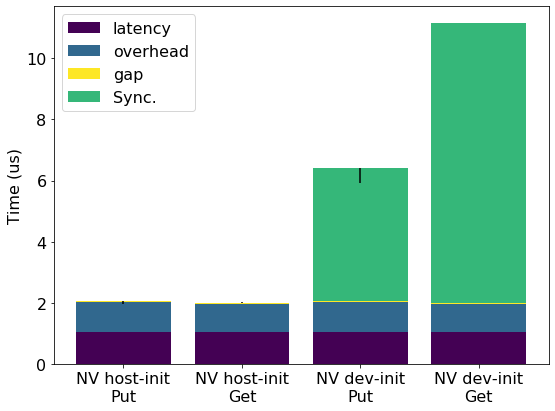

In [82]:
#This figure shows the difference that the wire and switch latency add for a single hop.
n = 4
colors = plt.cm.viridis(np.linspace(0,1,n))
c = 0
fig, ax = plt.subplots(figsize=(8,6))
#labels=["IBV host-init\n Read", "NV host-init\n", "NV host-init\nPut", "NV host-init\nGet", "NV dev-init\nPut", "NV dev-init\nGet"]
labels=["NV host-init\nPut", "NV host-init\nGet", "NV dev-init\nPut", "NV dev-init\nGet"]
x = np.arange(len(labels))
add_series = lambda x,y:[a+b for (a,b) in zip(x,y)]
ax.bar(range(len(means)), latencies, align='center', label='latency', color=colors[c])
c = c+1
ax.bar(range(len(means)), overheads, bottom=latencies, align='center', label='overhead', color=colors[c])
c = c+2
b = add_series(latencies, overheads)
ax.bar(range(len(means)), gaps, bottom=b, align='center', label='gap', color=colors[c])
c = c-1
b = add_series(b,gaps)
ax.bar(range(len(means)), syncs, bottom=b, align='center', label='Sync.', yerr=ebars, color=colors[c])

b = add_series(b,syncs)
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_title("Latency for VERBS and NVSHMEM 8B get ops.\n Host initiated, HBM2")
ax.set_ylabel("Time (us)")
plt.legend()
matplotlib.rcParams.update({'font.size': 16})
fig.tight_layout()
plt.show()
fig.savefig("nvbreakdown.png")

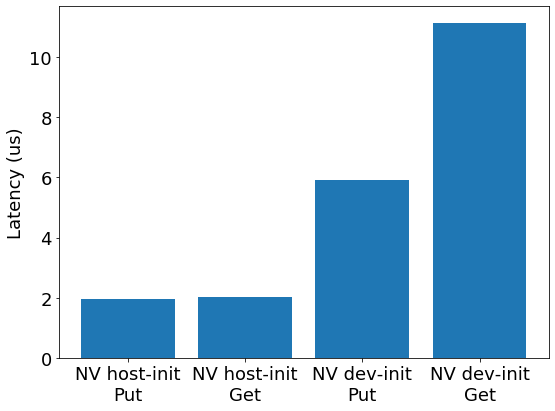

In [65]:
#This figure shows the difference that the wire and switch latency add for a single hop.
fig, ax = plt.subplots(figsize=(8,6))
#labels=["IBV host-init\n Read", "NV host-init\n", "NV host-init\nPut", "NV host-init\nGet", "NV dev-init\nPut", "NV dev-init\nGet"]
labels=["NV host-init\nPut", "NV host-init\nGet", "NV dev-init\nPut", "NV dev-init\nGet"]
x = np.arange(len(labels))
ax.bar(range(len(means)), means, align='center')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_title("Latency for VERBS and NVSHMEM 8B get ops.\n Host initiated, HBM2")
ax.set_ylabel("Latency (us)")
matplotlib.rcParams.update({'font.size': 16})
fig.tight_layout()
plt.show()
fig.savefig("8B-ibvsnv-hbm-latency-put-get.png")

In [35]:
o = (means[1]-means[0])/2

In [36]:
s = means[2]-(means[0]-o)

In [37]:
(means[3]-means[0])/2

4.675000000000001

In [38]:
o+s

4.749999999999999

In [40]:
s

4.4399999999999995

In [29]:
means = []
f = f_nv
tmp = read_nvshmem_lat(8, join(nvhostpath, f))
print(tmp)
means += [float(tmp["tavg"])]
f = f_nv_dev
tmp = read_nvshmem_lat(8, join(nvdevpath, f))
print(tmp)
means += [float(tmp["tavg"])]

{'tavg': '2.40'}
{'tavg': '11.13'}


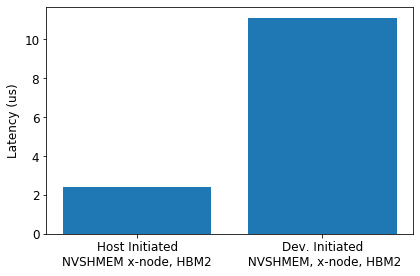

In [30]:
#This figure shows the difference between host and Device Initiated.
fig, ax = plt.subplots()
labels=["Host Initiated\nNVSHMEM x-node, HBM2", "Dev. Initiated\n NVSHMEM, x-node, HBM2"]
x = np.arange(len(labels))
ax.bar(range(len(means)), means, align='center')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_title("Latency for NVSHMEM 8B get ops.\n Host vs Device Control")
ax.set_ylabel("Latency (us)")
matplotlib.rcParams.update({'font.size': 12})
fig.tight_layout()
plt.show()
fig.savefig("8B-nv-hostvsdev-latency-put.png")

In [27]:
means

[1.78, 2.4]

In [28]:
meanshost = []
meansdev = []

for m in [2**x for x in range(3, 16)]:
    tmp = read_nvshmem_lat(m, join(nvhostpath, f_nv))
    print(tmp)
    meanshost += [float(tmp["tavg"])]
    f = f_nv_dev
    tmp = read_nvshmem_lat(m, join(nvdevpath, f_nv_dev))
    print(tmp)
    meansdev += [float(tmp["tavg"])]

{'tavg': '2.40'}
{'tavg': '11.13'}
{'tavg': '2.00'}
{'tavg': '10.58'}
{'tavg': '2.00'}
{'tavg': '10.68'}
{'tavg': '1.90'}
{'tavg': '10.71'}
{'tavg': '2.00'}
{'tavg': '10.84'}
{'tavg': '2.10'}
{'tavg': '10.56'}
{'tavg': '2.10'}
{'tavg': '10.61'}
{'tavg': '2.20'}
{'tavg': '10.67'}
{'tavg': '2.40'}
{'tavg': '11.17'}
{'tavg': '2.70'}
{'tavg': '11.39'}
{'tavg': '4.00'}
{'tavg': '12.25'}
{'tavg': '5.20'}
{'tavg': '13.43'}
{'tavg': '7.20'}
{'tavg': '15.66'}


In [30]:
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

xs=[2**x for x in range(3, 16)]
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit([[x] for x in xs], [[y] for y in meanshost])

# The coefficients
print('Coefficients: \n', regr.coef_)
print(regr.intercept_)

regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit([[x] for x in xs], [[y] for y in meansdev])

# The coefficients
print('Coefficients: \n', regr.coef_)
print(regr.intercept_)

Coefficients: 
 [[0.00016496]]
[2.10697862]
Coefficients: 
 [[0.00015465]]
[10.73433033]


In [34]:
for v in meanshost:
    print(v)

2.4
2.0
2.0
1.9
2.0
2.1
2.1
2.2
2.4
2.7
4.0
5.2
7.2
